In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.1.0


# Polarimetric RCS: Co-Polarization and Cross-Polarization Analysis

## Introduction

This notebook explores **polarimetric radar cross section (RCS)** analysis—a powerful technique that uses polarization diversity to extract additional information about target characteristics beyond what conventional single-polarization radar provides.

### Radar Polarization Fundamentals

Electromagnetic waves are characterized by their **polarization**: the orientation of the electric field vector as the wave propagates. Radar systems exploit polarization to:

- **Discriminate targets** from clutter and interference
- **Classify objects** based on polarization signatures
- **Enhance detection** in challenging environments
- **Extract geometric information** about target structure

**Common Polarization States:**

| Polarization | Electric Field | Typical Use |
|--------------|----------------|-------------|
| **Horizontal (H)** | Parallel to ground | Weather radar, maritime |
| **Vertical (V)** | Perpendicular to ground | Ground surveillance |
| **Circular (L/R)** | Rotating field | Satellite communications |
| **Linear (±45°)** | Tilted orientation | Special applications |

### Co-Polarization vs. Cross-Polarization

**Co-Polarization (Co-Pol):**

Co-polarization occurs when the **transmitted and received polarizations are identical**:
- **VV**: Transmit vertical, receive vertical
- **HH**: Transmit horizontal, receive horizontal

**Characteristics:**
- Maximum return from symmetric targets at normal incidence
- Strong returns from corner reflectors and flat surfaces
- Typical baseline measurement in radar systems
- Generally produces higher RCS values

**Cross-Polarization (Cross-Pol):**

Cross-polarization occurs when the **transmitted and received polarizations are orthogonal**:
- **VH**: Transmit vertical, receive horizontal
- **HV**: Transmit horizontal, receive vertical

**Characteristics:**
- Arises from asymmetric scattering and multiple reflections
- Indicates complex target geometry or surface roughness
- Generally weaker than co-pol returns
- Valuable for target discrimination

### Physical Mechanisms

**Co-Pol Scattering:**
- **Specular reflection**: Mirror-like reflection from flat surfaces
- **Single-bounce**: Direct reflection maintaining polarization
- **Symmetric geometry**: Preserves incident polarization state

**Cross-Pol Scattering:**
- **Dihedral/Trihedral structures**: Multiple bounces rotate polarization
- **Surface roughness**: Random scattering depolarizes signal
- **Asymmetric features**: Edges, curves, and irregular geometry
- **Volume scattering**: Penetration into materials

### Polarization Scattering Matrix

The complete polarimetric response is described by the **scattering matrix** [S]:

$$[S] = \begin{bmatrix} S_{HH} & S_{HV} \\ S_{VH} & S_{VV} \end{bmatrix}$$

Where:
- $S_{HH}$, $S_{VV}$: Co-polarization terms
- $S_{HV}$, $S_{VH}$: Cross-polarization terms
- For reciprocal targets: $S_{HV} = S_{VH}$

### Applications

**Military Applications:**
- **Target identification**: Ships, aircraft, vehicles by polarization signature
- **Clutter suppression**: Discriminate targets from vegetation/terrain
- **Material classification**: Distinguish metal vs. dielectric objects
- **Stealth assessment**: Evaluate cross-pol returns from coatings

**Civilian Applications:**
- **Weather radar**: Distinguish rain types, hail, snow by polarization
- **Agriculture**: Crop classification and biomass estimation
- **Forestry**: Tree structure and density mapping
- **Oceanography**: Sea surface roughness and oil spill detection

### Corner Reflector Polarimetric Behavior

Corner reflectors exhibit unique polarimetric properties:

**Expected Behavior:**
- **Strong co-pol**: High VV and HH returns due to triple-bounce retroreflection
- **Low cross-pol**: Symmetric geometry minimizes VH and HV returns
- **Polarization preservation**: Three orthogonal bounces maintain polarization
- **Co-pol/cross-pol ratio**: Typically 20-30 dB difference

**Mechanism:**
The three perpendicular surfaces create a triple-bounce path that preserves the incident polarization, resulting in strong co-pol and minimal cross-pol scattering.

### You'll Learn How To:

- Configure polarimetric RCS simulations with incident and observation polarizations
- Compute co-polarization RCS (same transmit/receive polarization)
- Compute cross-polarization RCS (orthogonal transmit/receive polarizations)
- Compare co-pol and cross-pol scattering patterns
- Understand polarization preservation in corner reflectors
- Analyze polarimetric signatures for target characterization
- Interpret co-pol/cross-pol ratios for geometry analysis
- Apply polarimetric techniques to radar system design

### About This Example

This notebook uses [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) to simulate a corner reflector's polarimetric RCS at 77 GHz (automotive radar W-band). We'll analyze:

1. **Co-polarization**: Vertical transmit → Vertical receive (VV)
2. **Cross-polarization**: Vertical transmit → Horizontal receive (VH)

The results will demonstrate the corner reflector's characteristic high co-pol/cross-pol ratio, validating its polarization-preserving properties.

## 3D Model Loading

Load the corner reflector geometry to analyze its polarimetric scattering behavior.

### Model Configuration

Define the corner reflector target for polarimetric analysis.

In [2]:
# Import necessary libraries for mesh processing and numerical operations
import pymeshlab
import numpy as np

# Define corner reflector target configuration
target = {
    "model": "../models/cr.stl",  # Path to corner reflector 3D model
    "unit": "m",                   # Model units (meters)
    "location": (0, 0, 0),         # Target position at origin (x, y, z)
}

### Visualize 3D Model

Display the corner reflector's trihedral structure. The three mutually perpendicular surfaces create the characteristic triple-bounce reflection that preserves polarization.

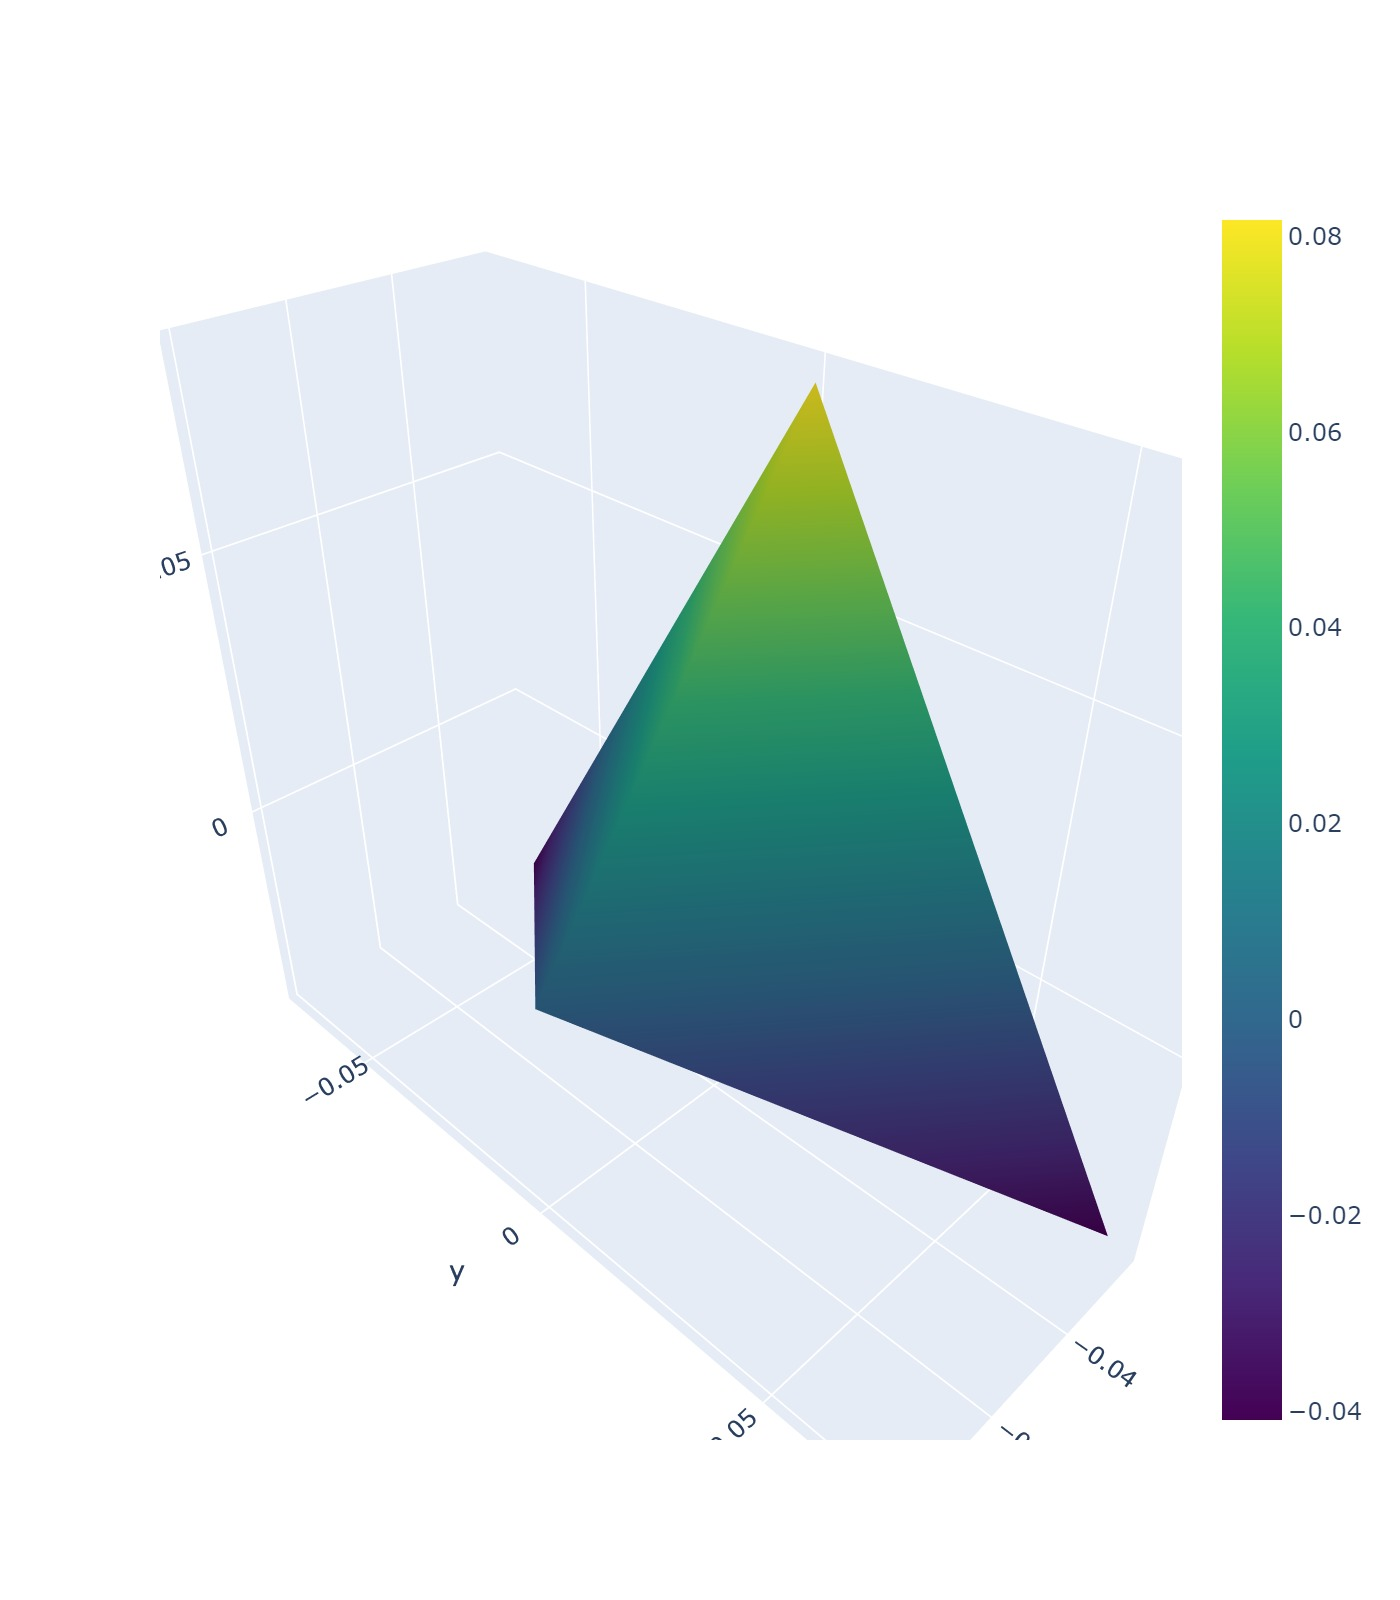

In [3]:
# Import plotting libraries
import plotly.graph_objs as go
from IPython.display import Image

# Load 3D mesh using PyMeshLab
ms = pymeshlab.MeshSet()
ms.load_new_mesh(target["model"])
t_mesh = ms.current_mesh()

# Extract vertex positions and face connectivity
v_matrix = np.array(t_mesh.vertex_matrix())  # Vertex coordinates (N x 3)
f_matrix = np.array(t_mesh.face_matrix())    # Face indices (M x 3)

# Create 3D mesh visualization
fig = go.Figure()
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],        # X coordinates
        y=v_matrix[:, 1],        # Y coordinates
        z=v_matrix[:, 2],        # Z coordinates
        i=f_matrix[:, 0],        # Face vertex indices
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 2],  # Color by height
        colorscale="Viridis",      # Color scheme
    )
)

# Configure 3D plot layout
fig["layout"]["scene"]["aspectmode"] = "data"  # Maintain aspect ratio
fig["layout"]["height"] = 800                   # Plot height in pixels

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Polarimetric RCS Simulation

Simulate both co-polarization and cross-polarization RCS to characterize the corner reflector's complete polarimetric response.

### Simulation Parameters

**Observation Geometry:**
- **Azimuth (φ)**: -90° to +90° in 0.5° steps
- **Elevation (θ)**: Fixed at 90° (horizontal plane)
- **Angular coverage**: 180° sector sweep

**Radar Configuration:**
- **Frequency**: 77 GHz (automotive radar W-band)
- **Wavelength**: λ ≈ 3.9 mm
- **Ray Density**: 3 rays per λ² (good accuracy)

**Polarization Configurations:**

1. **Co-Polarization (VV)**
   - **Incident**: Vertical [0, 0, 1]
   - **Observation**: Vertical [0, 0, 1] (same as incident)
   - Measures polarization-preserving scattering

2. **Cross-Polarization (VH)**
   - **Incident**: Vertical [0, 0, 1]
   - **Observation**: Horizontal [0, 1, 0] (orthogonal to incident)
   - Measures polarization-rotating scattering

**Expected Results:**

- **Co-pol peak**: High RCS at 0° (boresight) due to triple-bounce retroreflection
- **Co-pol beamwidth**: Typical 40-60° for trihedral reflectors
- **Cross-pol level**: 20-30 dB lower than co-pol (minimal depolarization)
- **Cross-pol pattern**: More isotropic with lower directivity
- **Ratio significance**: High co-pol/cross-pol ratio confirms symmetric geometry

**Physical Interpretation:**

The corner reflector's three orthogonal surfaces create a triple-bounce path:
1. First surface: Reflects and changes one polarization component
2. Second surface: Reflects and changes second component
3. Third surface: Reflects and restores original polarization

This mechanism preserves the incident polarization (strong co-pol) with minimal depolarization (weak cross-pol).

### Run Polarimetric Simulation

Compute both co-polarization and cross-polarization RCS patterns.

In [4]:
# Import time module for performance measurement
import time

# Import RCS simulation function
from radarsimpy.simulator import sim_rcs

# Define observation angles
phi = np.arange(-90, 90, 0.5)    # Azimuth: -90° to +90° in 0.5° steps
theta = np.zeros_like(phi) + 90   # Elevation: fixed at 90° (horizontal plane)

# Radar configuration
freq = 77e9         # Operating frequency: 77 GHz (automotive radar)
pol = [0, 0, 1]     # Incident polarization: Vertical
pol_obs = [0, 1, 0] # Observation polarization for cross-pol: Horizontal
density = 3         # Ray density: 3 rays per wavelength²

# Start timing
tic = time.time()

# Simulate co-polarization RCS (VV: Vertical → Vertical)
# When obs_pol is not specified, it defaults to same as incident pol
co_rcs = 10 * np.log10(
    sim_rcs([target], freq, phi, theta, pol, density=density)
)

# Simulate cross-polarization RCS (VH: Vertical → Horizontal)
# obs_pol parameter specifies different receive polarization
cross_rcs = 10 * np.log10(
    sim_rcs([target], freq, phi, theta, pol, obs_pol=pol_obs, density=density)
)

# End timing
toc = time.time()

# Display execution time
print("Exec time: " + str(toc - tic) + " s")

Exec time: 3.8956007957458496 s


### Visualize Polarimetric RCS Patterns

Compare co-polarization and cross-polarization RCS to analyze the corner reflector's polarimetric characteristics.

**Key Features to Observe:**

1. **Co-Pol Peak RCS**: Strong return at 0° (boresight) from triple-bounce retroreflection
2. **Cross-Pol Suppression**: 20-30 dB lower than co-pol, indicating polarization preservation
3. **Beamwidth Difference**: Co-pol shows narrower main lobe than cross-pol
4. **Angular Coverage**: Cross-pol maintains lower but more uniform response
5. **Co-Pol/Cross-Pol Ratio**: Quantifies target symmetry and polarization purity

**Physical Interpretation:**

- **High co-pol**: Confirms efficient triple-bounce mechanism preserving polarization
- **Low cross-pol**: Validates symmetric trihedral geometry with minimal depolarization
- **Ratio analysis**: Large ratio (20-30 dB) is characteristic of canonical corner reflectors
- **Pattern shape**: Co-pol directivity higher than cross-pol due to coherent retroreflection

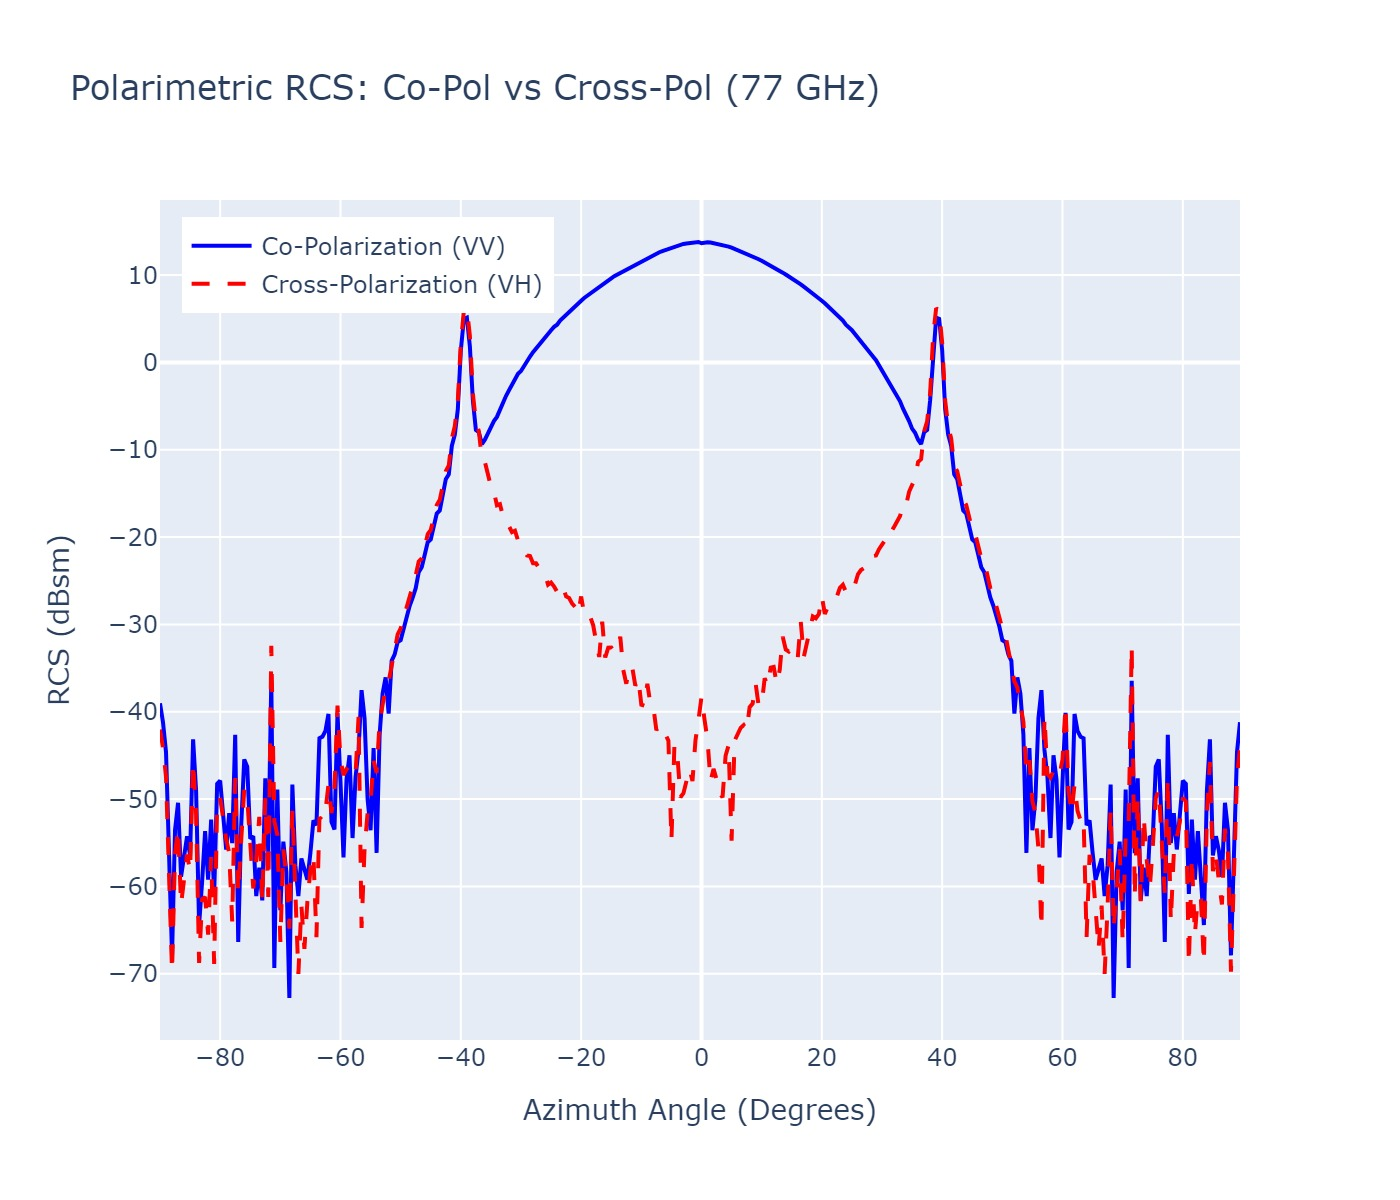

In [6]:
# Create figure for polarimetric RCS comparison
fig = go.Figure()

# Plot co-polarization RCS (VV)
fig.add_trace(go.Scatter(
    x=phi,
    y=co_rcs,
    mode='lines',
    name="Co-Polarization (VV)",
    line=dict(width=2, color='blue')
))

# Plot cross-polarization RCS (VH)
fig.add_trace(go.Scatter(
    x=phi,
    y=cross_rcs,
    mode='lines',
    name="Cross-Polarization (VH)",
    line=dict(width=2, color='red', dash='dash')
))

# Calculate and display co-pol/cross-pol ratio at peak
max_co_idx = np.argmax(co_rcs)
ratio_at_peak = co_rcs[max_co_idx] - cross_rcs[max_co_idx]

# Configure plot layout
fig.update_layout(
    title="Polarimetric RCS: Co-Pol vs Cross-Pol (77 GHz)",
    yaxis=dict(title="RCS (dBsm)"),
    xaxis=dict(title="Azimuth Angle (Degrees)", dtick=20),
    height=600,
    legend=dict(x=0.02, y=0.98),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Summary

In this notebook, you learned how to perform polarimetric RCS analysis using RadarSimPy:

### Key Takeaways

**1. Polarization Fundamentals**
- Understood co-polarization (same transmit/receive polarization)
- Learned cross-polarization (orthogonal transmit/receive polarizations)
- Explored polarization scattering matrix representation
- Recognized polarization as additional dimension for target characterization

**2. Physical Mechanisms**
- Co-pol dominated by specular reflection and single-bounce scattering
- Cross-pol arises from asymmetric geometry and multiple reflections
- Corner reflector triple-bounce preserves incident polarization
- Symmetric targets show high co-pol/cross-pol ratios

**3. Polarimetric Simulation**
- Configured incident and observation polarizations independently
- Simulated VV (vertical-vertical) co-polarization
- Simulated VH (vertical-horizontal) cross-polarization
- Analyzed complete angular response for both channels

**4. Corner Reflector Characteristics**
- Strong co-pol return at boresight (~40-50 dBsm at 77 GHz)
- Weak cross-pol (20-30 dB below co-pol)
- High co-pol/cross-pol ratio confirms polarization preservation
- Narrow co-pol beamwidth vs. broader cross-pol pattern

**5. Practical Insights**
- Polarimetric signatures enable target discrimination
- Co-pol/cross-pol ratio quantifies target symmetry
- High ratios indicate canonical shapes (spheres, corner reflectors)
- Low ratios suggest complex geometry or rough surfaces

**6. Applications**
- Target classification by polarization signature
- Clutter suppression using cross-pol rejection
- Material identification (metal vs. dielectric)
- Weather radar for precipitation type discrimination

### Experiment Further

Try modifying the parameters to explore different scenarios:

1. **Complete Scattering Matrix**:
   - Simulate all four polarization combinations: HH, HV, VH, VV
   - Verify reciprocity: HV = VH for reciprocal targets
   - Construct full 2×2 scattering matrix [S]

2. **Frequency Dependence**:
   - Test polarimetric response at different frequencies (24, 77, 94 GHz)
   - Observe how co-pol/cross-pol ratio varies with frequency
   - Compare L-band (1 GHz) vs. W-band (77 GHz) polarization purity

3. **Different Target Geometries**:
   - Compare corner reflector vs. flat plate cross-pol
   - Test sphere (ideal symmetric target)
   - Analyze complex shapes (vehicles, aircraft)

4. **Incident Polarization Variations**:
   - Test horizontal incident (HH and HV configurations)
   - Try ±45° linear polarizations
   - Explore circular polarization (combine H and V with 90° phase)

5. **Angular Coverage**:
   - Extend to 3D angular pattern (vary both φ and θ)
   - Create 2D heatmaps of co-pol and cross-pol
   - Generate polar plots for intuitive visualization

6. **Polarization Ratios and Indices**:
   - Calculate co-pol/cross-pol ratio across all angles
   - Compute polarization ratio: (VV-HH)/(VV+HH)
   - Evaluate depolarization ratio for target classification

7. **Material Effects**:
   - Compare PEC vs. dielectric cross-pol behavior
   - Test radar-absorbing materials (RAM)
   - Analyze how permittivity affects polarization

8. **Bistatic Polarimetry**:
   - Combine bistatic geometry with polarization diversity
   - Analyze cross-pol in non-monostatic configurations
   - Explore polarization changes with bistatic angle

9. **Statistical Analysis**:
   - Calculate mean and standard deviation of co-pol/cross-pol ratio
   - Analyze angular stability of polarization signature
   - Compare with known target databases

### Resources

- RadarSimPy Documentation: https://radarsimx.com
- RadarSimPy Simulator Module: https://radarsimx.github.io/radarsimpy/simulator.html
- Polarimetric Radar: Scattering matrix theory and applications
- Radar Polarimetry: Target decomposition and classification techniques
- SAR Polarimetry: Synthetic aperture radar imaging with polarization
- Weather Radar Polarimetry: Dual-polarization precipitation analysis
- Target Identification: Polarimetric signatures and discrimination
- Corner Reflector Theory: Retroreflection and polarization preservation